# Notebook 4: Model Training & Evaluation (Heart Disease Dataset)

In this notebook, we build and evaluate machine learning models using the **cleaned dataset** prepared in Notebook 3.  

**Goals**

- Train different models to predict heart disease.  
  
- Apply consistent preprocessing using pipelines.  
  
- Evaluate performance with robust metrics.  
  
- Identify the best-performing model for interpretation and future use.  

**Workflow**

1. Load cleaned dataset  
   
2. Define target and feature sets  
   
3. Split into training, validation, and test sets  
   
4. Standardize features  
   
5. Train baseline and advanced models  
   
6. Evaluate performance on validation and test sets  
   
7. Compare models and interpret results  
   
8. Save final models and document decisions  


---

In [35]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, RocCurveDisplay

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [36]:
data_path = "outputs/datasets/cleaned/heart_disease_cleaned_v2.csv"
df = pd.read_csv(data_path)
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()

Dataset loaded: 920 rows × 23 columns


,id,age,trestbps,chol,thalch,oldpeak,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,...,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,HeartDisease,chol_age_ratio,oldpeak_thalach_ratio,age_trestbps,thalch_oldpeak,age_group
0,1.0,63.0,145.0,233.0,150.0,2.3,True,False,False,False,...,True,False,False,False,0,3.698413,0.015333,9135.0,345.0,3.0
1,2.0,67.0,160.0,286.0,108.0,1.5,True,False,False,False,...,False,False,False,True,1,4.268657,0.013889,10720.0,162.0,3.0
2,3.0,67.0,120.0,229.0,129.0,2.6,True,False,False,False,...,False,False,False,True,1,3.417910,0.020155,8040.0,335.4,3.0
3,4.0,37.0,130.0,250.0,187.0,3.5,True,False,False,False,...,False,True,False,False,0,6.756757,0.018717,4810.0,654.5,0.0
4,5.0,41.0,130.0,204.0,172.0,1.4,False,False,False,False,...,False,False,False,False,0,4.975610,0.008140,5330.0,240.8,1.0


In [37]:
X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

# Stratified train/val/test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train shape:", X_train.shape, "Validation shape:", X_val.shape, "Test shape:", X_test.shape)


Train shape: (644, 22) Validation shape: (138, 22) Test shape: (138, 22)


In [38]:
numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [39]:
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(random_state=42))
])

pipeline_lr_smote = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

pipeline_lgbm = Pipeline([
    ("preprocessor", preprocessor),
    ("lgbm", LGBMClassifier(random_state=42))
])

/home/cistudent/.local/lib/python3.12/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [40]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

--- Logistic Regression ---
              precision    recall  f1-score   support

           0      0.721     0.721     0.721        61
           1      0.779     0.779     0.779        77

    accuracy                          0.754       138
   macro avg      0.750     0.750     0.750       138
weighted avg      0.754     0.754     0.754       138

ROC-AUC: 0.8137108792846497


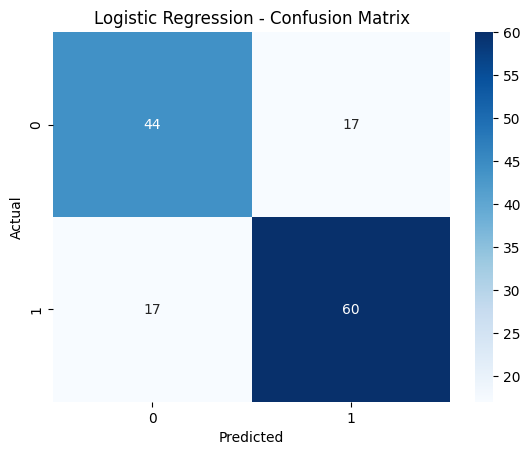

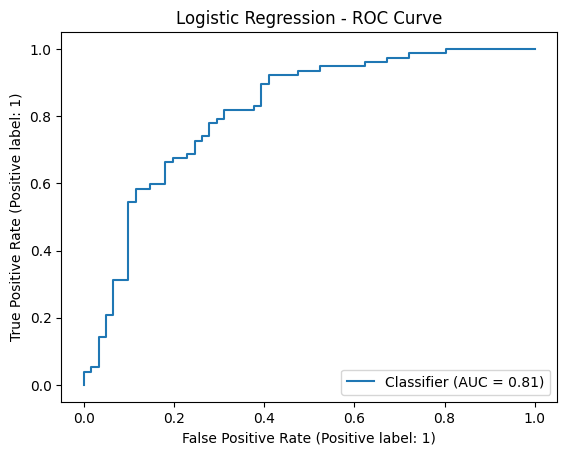

--- Random Forest ---
              precision    recall  f1-score   support

           0      0.833     0.738     0.783        61
           1      0.810     0.883     0.845        77

    accuracy                          0.819       138
   macro avg      0.821     0.810     0.814       138
weighted avg      0.820     0.819     0.817       138

ROC-AUC: 0.8869491164573132


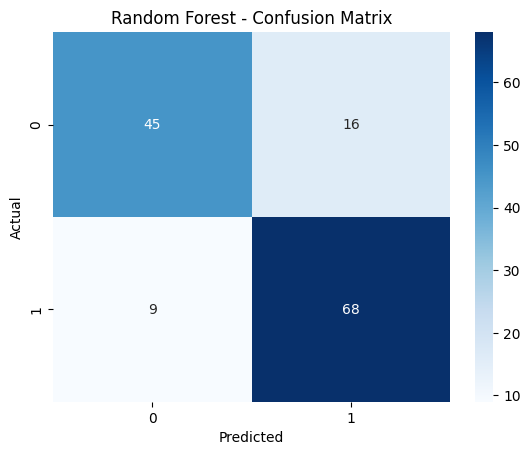

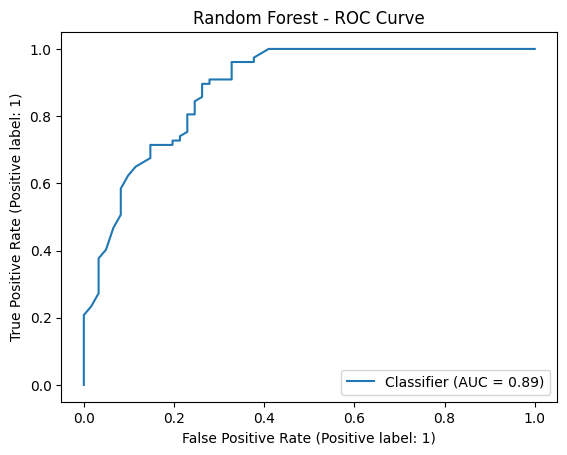

--- Logistic Regression + SMOTE ---
              precision    recall  f1-score   support

           0      0.697     0.754     0.724        61
           1      0.792     0.740     0.765        77

    accuracy                          0.746       138
   macro avg      0.744     0.747     0.745       138
weighted avg      0.750     0.746     0.747       138

ROC-AUC: 0.8164786033638493


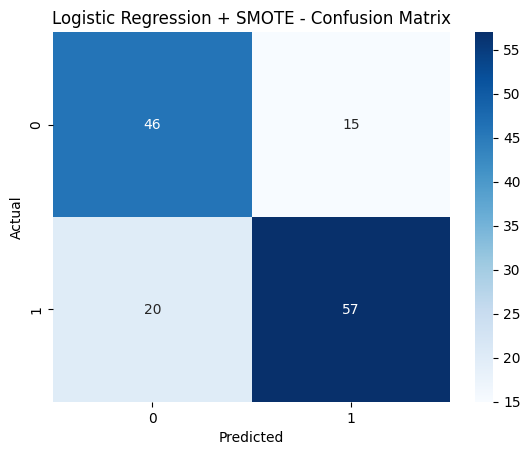

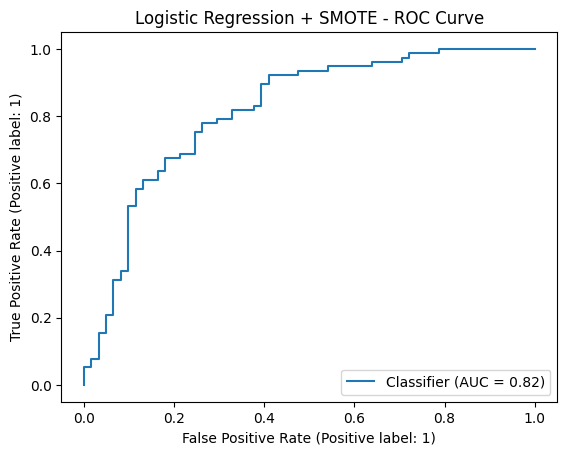

/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


--- XGBoost ---
              precision    recall  f1-score   support

           0      0.786     0.721     0.752        61
           1      0.793     0.844     0.818        77

    accuracy                          0.790       138
   macro avg      0.789     0.783     0.785       138
weighted avg      0.790     0.790     0.789       138

ROC-AUC: 0.8801362571854375


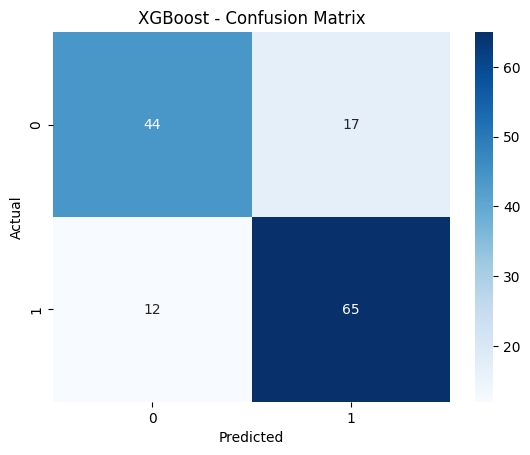

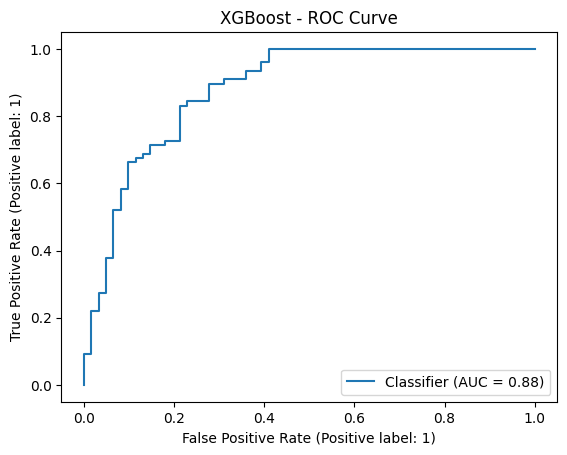

[LightGBM] [Info] Number of positive: 356, number of negative: 288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552795 -> initscore=0.211970
[LightGBM] [Info] Start training from score 0.211970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

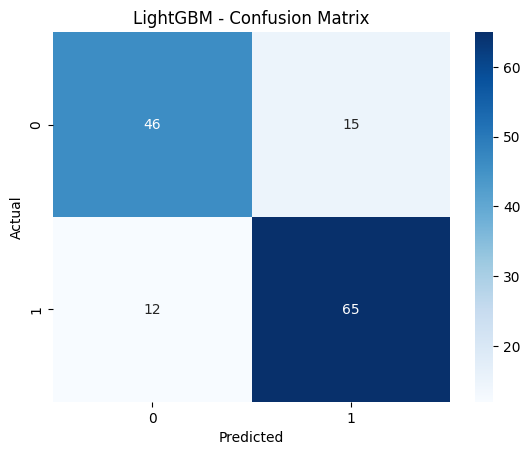

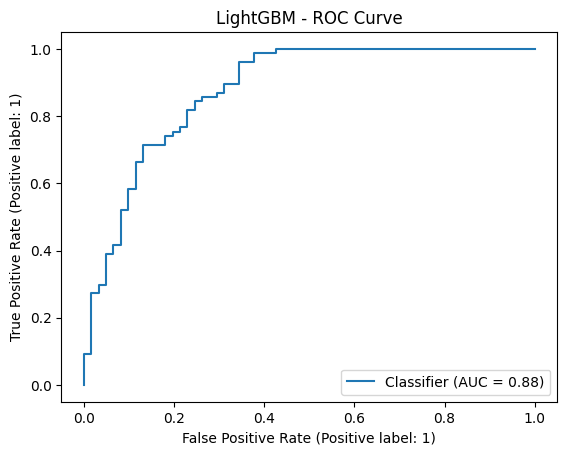

,Model,Dataset,Accuracy,F1,ROC-AUC
0,Logistic Regression,Validation,0.753623,0.779221,0.813711
1,Random Forest,Validation,0.818841,0.844720,0.886949
2,Logistic Regression + SMOTE,Validation,0.746377,0.765101,0.816479
3,XGBoost,Validation,0.789855,0.817610,0.880136
4,LightGBM,Validation,0.804348,0.828025,0.878007


In [41]:
models = {
    "Logistic Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "Logistic Regression + SMOTE": pipeline_lr_smote,
    "XGBoost": pipeline_xgb,
    "LightGBM": pipeline_lgbm
}

results_val = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    evaluate_model(y_val, y_val_pred, y_val_proba, name)
    
    results_val.append({
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": (y_val_pred == y_val).mean(),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc_score(y_val, y_val_proba)
    })

results_val_df = pd.DataFrame(results_val)
results_val_df

In [42]:
os.makedirs("models", exist_ok=True)
joblib.dump([X_train, X_val, X_test, y_train, y_val, y_test], "models/splits_v2.pkl")
joblib.dump(models, "models/baseline_models_v2.pkl")
print("✅ Data splits and baseline models saved for Notebook 5")

✅ Data splits and baseline models saved for Notebook 5


---

## 4.1 Import Libraries

**Purpose:** 

Load all packages used for data handling, visualization, preprocessing, model training, and evaluation.

**Approach:**

- Data & plotting: pandas, numpy, matplotlib, seaborn, os.

- Persistence: joblib for saving models and pipelines.

- Modeling: scikit-learn utilities for splitting, transforms (StandardScaler, OneHotEncoder, ColumnTransformer),

pipelines, estimators (Logistic Regression, Random Forest), and metrics (accuracy, precision, recall, F1, ROC-AUC, 

confusion matrix, ROC curve).

**Expected Outcome:** 

Environment is ready and consistent for the rest of the notebook.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)

---

## 4.2 Load Cleaned Dataset

**Purpose:** 

Load the cleaned, model-ready dataset created in Notebook 3.

**Approach:**  

- Read outputs/datasets/cleaned/heart_disease_cleaned.csv with pd.read_csv(...).

- Print column names and the first rows to verify structure.

- Confirm dataset shape (rows × columns).

**Expected Outcome:** 

A verified DataFrame df containing clean inputs and a properly defined HeartDisease target.

**Checks:**  

- Verify the number of rows and columns  
  
- Confirm that there are no missing values 
   
- Inspect column names to ensure proper preprocessing from Notebook 3

In [19]:
df = pd.read_csv('outputs/datasets/cleaned/heart_disease_cleaned.csv')
print(df.columns.tolist())   # see all column names
print(df.head())  

rows, cols = df.shape
print(f"✅ The dataset has {rows} rows and {cols} columns.")


['id', 'age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'sex_Male', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'HeartDisease', 'num']
   id  age  trestbps   chol    fbs  thalch  exang  oldpeak  sex_Male  \
0   1   63     145.0  233.0   True   150.0  False      2.3      True   
1   2   67     160.0  286.0  False   108.0   True      1.5      True   
2   3   67     120.0  229.0  False   129.0   True      2.6      True   
3   4   37     130.0  250.0  False   187.0  False      3.5      True   
4   5   41     130.0  204.0  False   172.0  False      1.4     False   

   dataset_Hungary  dataset_Switzerland  dataset_VA Long Beach  \
0            False                False                  False   
1            False                False                  False   
2            False                False                  False   
3            False     

---

## 4.3 Define Features and Target

**Purpose:** 

Separate predictors from the target for supervised learning and guard against leakage.

**Approach:**  

- Build X by dropping non-predictive / leakage-prone columns: ["HeartDisease", "num", "id", "dataset_Hungary", 

"dataset_Switzerland", "dataset_VA Long Beach"].

- Set y = df["HeartDisease"].

- Visualize target balance with a count plot.

- Identify categorical_features and numeric_features from X based on dtypes.

**Expected Outcome:**  

- X: clean predictor matrix.
  
- y: binary target vector.

- Clear view of target class distribution and feature type splits.

**Additional Checks:**  

- Inspect class distribution of the target  
  
- Identify numeric and categorical features separately

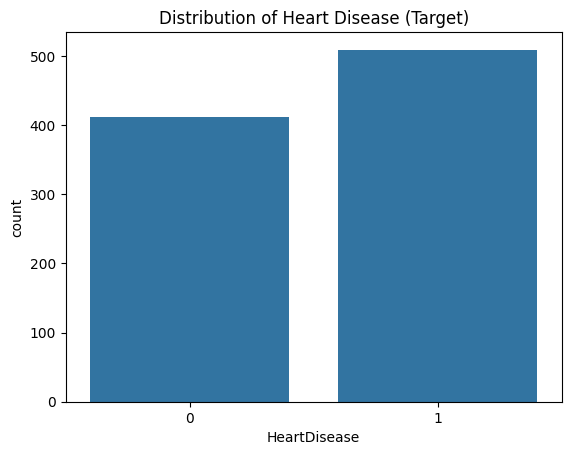

Features shape: (920, 13)
Target shape: (920,)
Remaining feature columns: ['age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality']
Categorical features: []
Numeric features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']


In [20]:
# Distribution of HeartDisease
X = df.drop(columns=["HeartDisease", "num", "id", 
                     "dataset_Hungary", "dataset_Switzerland", "dataset_VA Long Beach"])  
y = df["HeartDisease"]

sns.countplot(x=y)
plt.title("Distribution of Heart Disease (Target)")
plt.show()

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Remaining feature columns:", X.columns.tolist())

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)



---

## 4.4 Split Data

**Purpose:** 

Create independent training, validation, and test sets for reliable evaluation.

**Approach:**  

- First split: train vs. temp (test_size=0.3, stratify=y, random_state=42).

- Second split: temp → validation vs. test (50/50), stratified.

- Print shapes and class distributions to verify balance across splits.

**Expected Outcome:**  

- `X_train`, `X_val`, `X_test` and corresponding `y_train`, `y_val`, `y_test` 
   

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

print("\n✅ Class distribution in Train:")
print(y_train.value_counts(normalize=True))
print("\n✅ Class distribution in Validation:")
print(y_val.value_counts(normalize=True))
print("\n✅ Class distribution in Test:")
print(y_test.value_counts(normalize=True))



Train size: (644, 13)
Validation size: (138, 13)
Test size: (138, 13)

✅ Class distribution in Train:
HeartDisease
1    0.552795
0    0.447205
Name: proportion, dtype: float64

✅ Class distribution in Validation:
HeartDisease
1    0.557971
0    0.442029
Name: proportion, dtype: float64

✅ Class distribution in Test:
HeartDisease
1    0.550725
0    0.449275
Name: proportion, dtype: float64


---

## 4.5 Feature Scaling

**Purpose:** 

Normalize numeric features and encode categorical features, ensuring consistent, leak-free preprocessing.

**Approach:**  

- ColumnTransformer with two branches:

    - Numeric → StandardScaler()

    - Categorical → OneHotEncoder(drop='first', sparse_output=False) (dense output; drop first level to avoid dummy trap)
  
- Keep column order stable via the transformer.

**Expected Outcome:**  

A reusable preprocessor object that applies the exact same transformations during training and inference.

In [22]:
# ## 4.5 Define Preprocessing Pipeline
# Numeric features → StandardScaler
# Categorical features → OneHotEncoder
# Combine using ColumnTransformer

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

---

## 4.6 Define Models

**Purpose:** 

Bundle preprocessing and the estimator to eliminate leakage and simplify training/evaluation.

**Approach:**  

- Logistic Regression pipeline: ("preprocessor", preprocessor) → ("log_reg", LogisticRegression(...))
  
- Random Forest pipeline: ("preprocessor", preprocessor) → ("rf", RandomForestClassifier(...))
   
- Set fixed random_state for reproducibility.

**Expected Outcome:**  

Two end-to-end pipelines (pipeline_lr, pipeline_rf) that can be .fit() and .predict() safely.

In [23]:


pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

---

## 4.8 Train Models

**Purpose:** 

Fit the pipelines on the training data only.

**Approach:**  

- Call .fit(X_train, y_train) on both pipelines.
  
- Allow Logistic Regression to reach convergence with max_iter=1000.

**Expected Outcome:**  

Trained pipeline_lr and pipeline_rf ready for validation.

In [24]:
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalch', 'oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [])])),
                ('rf', RandomForestClassifier(random_state=42))])

## 4.9 Predict on Validation Set

**Purpose:** 

Generate validation predictions and probabilities for both models and compare their agreement.

**Approach:**  

- Use .predict(X_val) and .predict_proba(X_val)[:, 1] for LR and RF.

- Compute the share of identical predictions between the two models as a quick sanity check.

**Expected Outcome:**  

y_val_pred_* and y_val_proba_* arrays for downstream metrics; a rough idea of model similarity.

In [25]:
y_val_pred_lr = pipeline_lr.predict(X_val)
y_val_proba_lr = pipeline_lr.predict_proba(X_val)[:, 1]

y_val_pred_rf = pipeline_rf.predict(X_val)
y_val_proba_rf = pipeline_rf.predict_proba(X_val)[:, 1]

same_preds = (y_val_pred_lr == y_val_pred_rf).mean()
print(f"\n🤖 Logistic Regression vs Random Forest predictions identical: {same_preds*100:.2f}%")


🤖 Logistic Regression vs Random Forest predictions identical: 89.86%


## 4.10 Define Evaluation Helper

**Purpose:** 

Centralize common evaluation steps for consistent reporting across models.

**Approach:**  

- Print classification_report (precision, recall, F1, support).

- Compute ROC-AUC from probabilities.

- Plot confusion matrix and ROC curve with standard formatting.

**Expected Outcome:**  

A reusable evaluate_model(...) function that emits both text metrics and diagnostic plots.

In [26]:


def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

## 4.11 Initial Validation Evaluation

**Purpose:** 

Run the evaluation helper on the Logistic Regression validation predictions.

**Approach:**  

- Call evaluate_model(...) for Logistic Regression using y_val, y_val_pred_lr, and y_val_proba_lr.

- (Random Forest is evaluated later in 4.15 alongside LR for side-by-side plots.)

**Expected Outcome:**  

Baseline validation metrics and plots for Logistic Regression.

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.71      0.64      0.67        61
           1       0.73      0.79      0.76        77

    accuracy                           0.72       138
   macro avg       0.72      0.72      0.72       138
weighted avg       0.72      0.72      0.72       138

ROC-AUC: 0.7709176069831808


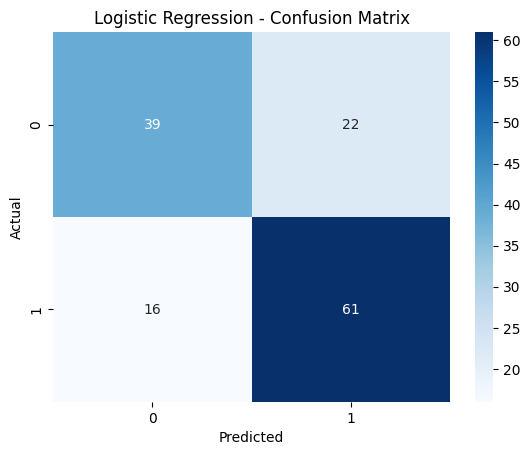

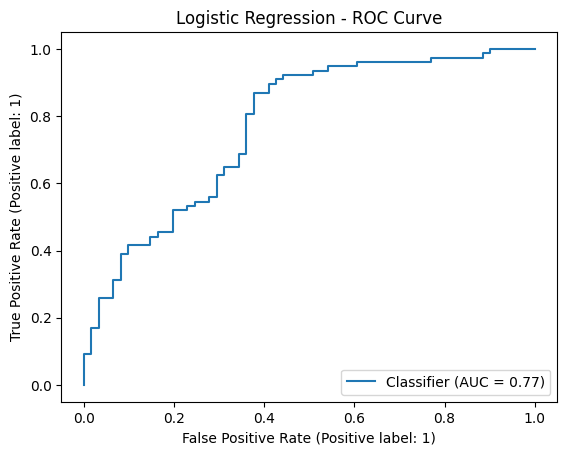

In [27]:


evaluate_model(y_val, y_val_pred_lr, y_val_proba_lr, "Logistic Regression")
## 4.12 Scaling Check
# Verify that numeric features are actually scaled.evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, "Random Forest")

## 4.12 Scaling Check (Diagnostic)

**Purpose:** 

Verify that numeric features are actually rescaled by the preprocessor.

**Approach:**  

- Apply preprocessor.fit_transform(X_train) then .transform(X_val)/.transform(X_test).

- Compare the raw X_val[numeric_features] to the first block of transformed columns to compute an average absolute
 
difference.

**Expected Outcome:**  

A numeric signal that scaling modified distributions (diff > 0 typically indicates scaling took effect).

*Note*

This is a diagnostic only. The refit of preprocessor here does not alter the already-trained pipelines; it’s separate 

and used to check the transformation effect.

In [28]:


# Apply preprocessor to training, validation, and test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed   = preprocessor.transform(X_val)
X_test_processed  = preprocessor.transform(X_test)

print("Train processed shape:", X_train_processed.shape)
print("Validation processed shape:", X_val_processed.shape)
print("Test processed shape:", X_test_processed.shape)

diff = np.abs(X_val[numeric_features].values - X_val_processed[:, :len(numeric_features)]).mean()
print(f"🔎 Average absolute difference after scaling: {diff:.6f}")

if diff < 1e-8:
    print("⚠️ Scaling had no effect (features may already be normalized/binary)")
else:
    print("✅ Scaling changed numeric feature distributions")

Train processed shape: (644, 5)
Validation processed shape: (138, 5)
Test processed shape: (138, 5)
🔎 Average absolute difference after scaling: 114.345740
✅ Scaling changed numeric feature distributions


## 4.13 Feature Correlation Check (Leakage Scan)

**Purpose:** 

Screen for suspiciously high linear correlations between predictors and the target that might indicate leakage.

**Approach:**  

- Compute df.corr()["HeartDisease"] and sort.

- Flag any absolute correlations > 0.95 (excluding the target itself).

**Expected Outcome:**  

A quick printed list of high-risk features (if any) to be reviewed.

In [29]:


corr = df.corr()["HeartDisease"].sort_values(ascending=False)
print("\n🔎 Feature correlations with HeartDisease:\n", corr)

suspect = corr[(corr.abs() > 0.95) & (corr.index != "HeartDisease")]
if not suspect.empty:
    print("\n⚠️ Potential leakage detected! Features highly correlated with target:")
    print(suspect)
else:
    print("\n✅ No features show suspiciously high correlation with target.")


🔎 Feature correlations with HeartDisease:
 HeartDisease                1.000000
num                         0.783387
exang                       0.433605
oldpeak                     0.366138
id                          0.356086
sex_Male                    0.307284
dataset_Switzerland         0.301614
age                         0.282700
dataset_VA Long Beach       0.203267
trestbps                    0.111305
fbs                         0.108071
restecg_st-t abnormality    0.104750
chol                        0.089008
cp_typical angina          -0.054673
restecg_normal             -0.093554
cp_non-anginal             -0.209812
dataset_Hungary            -0.263297
thalch                     -0.381864
cp_atypical angina         -0.403465
Name: HeartDisease, dtype: float64

✅ No features show suspiciously high correlation with target.


## 4.14 Feature Importance (Random Forest)

**Purpose:** 

Interpret the Random Forest by ranking features according to impurity-based importance.

**Approach:**  

- Recover output feature names by concatenating:

  - Original numeric features, and

  - One-hot encoded categorical feature names via preprocessor.named_transformers_['cat'].get_feature_names_out(...).

- Extract pipeline_rf.named_steps['rf'].feature_importances_.

- Display a sorted table and bar plot.

**Expected Outcome:**  

A ranked view of predictors contributing most to the RF model.

    feature  importance
3    thalch    0.262737
4   oldpeak    0.209669
0       age    0.203071
2      chol    0.199221
1  trestbps    0.125302


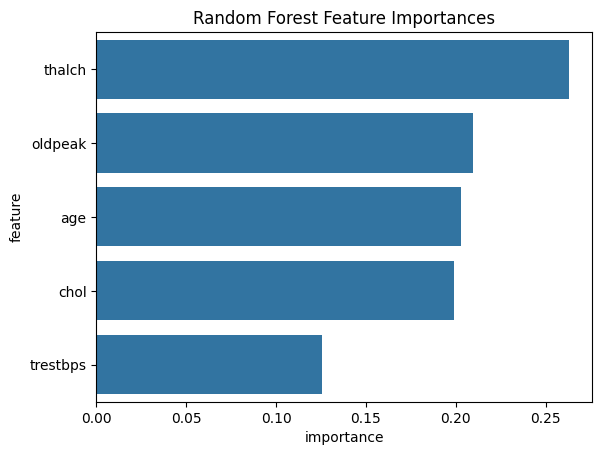

In [30]:


# Numeric features are always present
num_features = numeric_features  # ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

# Check if there are categorical features
if categorical_features:
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = list(num_features) + list(cat_features)
else:
    feature_names = list(num_features)

# Random Forest feature importances
importances = pipeline_rf.named_steps['rf'].feature_importances_

# Create dataframe for plotting
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp_df)

# Plot
sns.barplot(x="importance", y="feature", data=feat_imp_df)
plt.title("Random Forest Feature Importances")
plt.show()

## 4.15 Evaluate Models on Validation Set (with plots)

**Purpose:** 

Compare Logistic Regression and Random Forest on the same validation data, side-by-side.

**Approach:**  

- Call evaluate_model(...) for both models using the previously computed predictions/probabilities.

- Print the percentage of identical predictions for additional context.

**Expected Outcome:**  

Direct visual and numeric comparison to inform which model to carry forward.

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.71      0.64      0.67        61
           1       0.73      0.79      0.76        77

    accuracy                           0.72       138
   macro avg       0.72      0.72      0.72       138
weighted avg       0.72      0.72      0.72       138

ROC-AUC: 0.7709176069831808


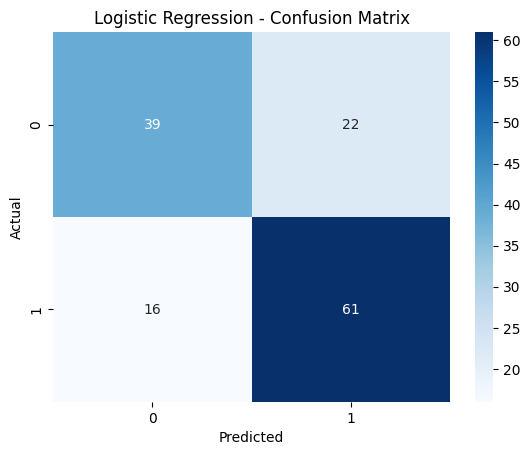

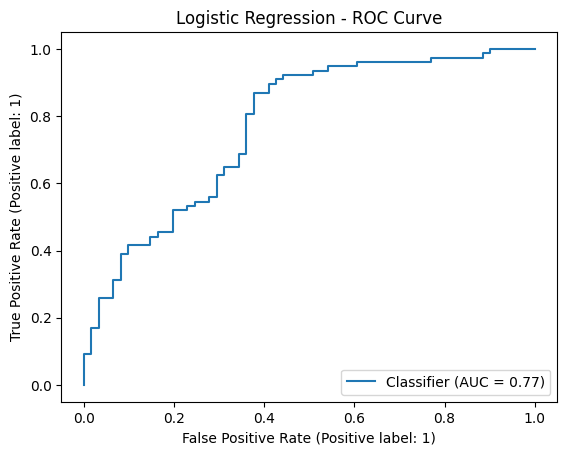

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        61
           1       0.73      0.73      0.73        77

    accuracy                           0.70       138
   macro avg       0.69      0.69      0.69       138
weighted avg       0.70      0.70      0.70       138

ROC-AUC: 0.7648499041941665


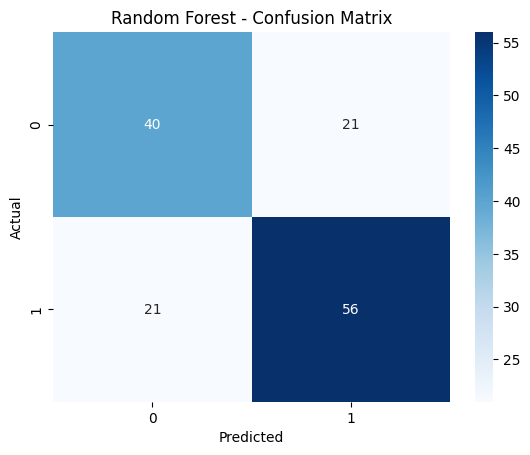

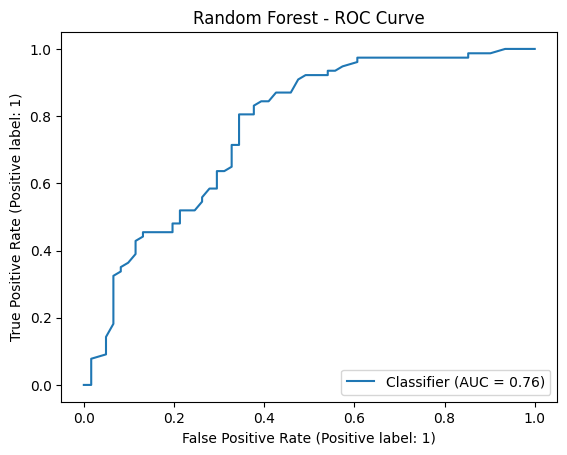


🤖 Logistic Regression vs Random Forest predictions identical: 89.86% of the time


In [31]:


evaluate_model(y_val, y_val_pred_lr, y_val_proba_lr, "Logistic Regression")
evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, "Random Forest")

# Compare predictions across models
same_preds = (y_val_pred_lr == y_val_pred_rf).mean()
print(f"\n🤖 Logistic Regression vs Random Forest predictions identical: {same_preds*100:.2f}% of the time")

## 4.16 Save Best Model

**Purpose:** 

Persist the preprocessor, trained pipelines, and dataset splits for reproducibility and deployment.

**Approach:**  

- Ensure a models/ directory exists.
  
- Save:

    - preprocessor.pkl

    - pipeline_log_reg.pkl

    - pipeline_random_forest.pkl

    - splits.pkl containing (X_train, X_val, X_test, y_train, y_val, y_test)

**Expected Outcome:**  

Versioned artifacts that can be loaded later without retraining, ensuring consistent preprocessing at inference time.



In [32]:
df = pd.read_csv('outputs/datasets/cleaned/heart_disease_cleaned_v2.csv')

X = df.drop(columns=["HeartDisease", "num", "id", 
                     "dataset_Hungary", "dataset_Switzerland", "dataset_VA Long Beach"])
y = df["HeartDisease"]

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [33]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop=None, sparse_output=False), categorical_features)
])

In [34]:
os.makedirs("models", exist_ok=True)

joblib.dump(preprocessor, "models/preprocessor.pkl")
joblib.dump(pipeline_lr, "models/pipeline_log_reg.pkl")
joblib.dump(pipeline_rf, "models/pipeline_random_forest.pkl")
joblib.dump((X_train, X_val, X_test, y_train, y_val, y_test), "models/splits.pkl")

print("✅ Preprocessor and pipelines saved successfully")

✅ Preprocessor and pipelines saved successfully


---


---

# ✅ Conclusions & Next Steps

### What we achieved in this notebook

1) Loaded cleaned data and defined X/y with leakage-prone columns removed.
   
2) Split data into train/val/test with stratification for stable class balance.
   
3) Built a ColumnTransformer (scaling + one-hot encoding) and wrapped it into two pipelines.
   
4) Trained Logistic Regression and Random Forest and evaluated them on the validation set.
   
5) Performed diagnostics (scaling check, correlation scan) and interpretability (RF feature importances).
   
6) Saved preprocessor, pipelines, and splits for reproducibility.

---

### Key Insights

- Pipelines prevent leakage and guarantee that transforms applied at training are identical at inference.
  
- Logistic Regression provides a strong, interpretable baseline; Random Forest captures non-linearities.
  
- Scaling visibly affects numeric features (confirmed by the diagnostic).
  
- No extreme (>0.95) correlations with the target suggests low leakage risk (if none were printed).

---

### Next Steps (Notebook 5 – Model Evaluation & Tuning)

- Evaluate both models on the held-out test set to report generalization.
  
- Perform hyperparameter tuning (Grid/RandomizedSearch) and re-evaluate on validation/test.
  
- Choose a final model balancing performance and interpretability.
  
- Save the final model as final_model.pkl and document the end-to-end predict workflow.